<center>
    
    The Longest Wordle
    
    Author: Daniel Coble
    
    Status: Work in Progress
</center>

The popular word game Wordle needs no introduction. The goal is to guess a secret word in as few guesses as possible, but what is the worst that someone could do at Wordle? For the problem to be well-defined and interesting, we have to specify *hard mode rules*, i.e. at every guess we can only guess another word which is valid. This is actually the premise of the Wordle variant, [Don't Wordle](https://dontwordle.com/), where the goal is to 'fail' Wordle under hard mode rules. By removing the six-word limit, we get the problem stated here, stated explicitly:
1. At every guess, information about the secret word is revealed according to Wordle rules.
2. All guesses must be valid words from the guessing word list and not be ruled out by previously revealed information.
3. The goal is to perform as many guesses as possible. Play ends when the player is forced to guess the secret word.

I say 'secret' word, but for our purposes, the guesser knowns the secret word before they begin. Mathematically, we represent this as a longest path search problem through a tree, where each node is a valid Wordle guess.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family':'monospace'})
"""
Load guesses and secret word lists from file into numpy array

The list of official guesses and answers as published by Cyrus Freshman (as of 9/2/2022):

allowed guesses: https://gist.github.com/cfreshman/d5fb56316158a1575898bba1eed3b5da
possible answers: https://gist.github.com/cfreshman/a7b776506c73284511034e63af1017ee
"""

guess_words = np.loadtxt("guess_words.txt", dtype=str)
secret_words = np.loadtxt("secret_words.txt", dtype=str)
print(guess_words.shape)
# guess list didn't contain secret_words
guess_words = np.append(guess_words, secret_words)

guess_words = np.array([[letter for letter in word] for word in guess_words]).astype('|S1')
secret_words = np.array([[letter for letter in word] for word in secret_words]).astype('|S1')

(12546,)


In [2]:
"""
Calculate Wordle for a secret word and guess. The result is encoded as a five element array with 
0 = gray
1 = yellow
2 = green
If asint=True, we take the result array and represent it as a ternary number.

Wordle rules: Greens take precent over yellow. In the case of repeated letters in the guess, the earliest takes precendent.
The same letter will only appear yellow with multiplicity if it appears with multiplicity in the secret word.
"""
def wordle(secret, guess, asint=False):
    # first check greens
    greens = secret == guess
    # fill green spaces with blank to avoid showing as yellow
    secret_ = np.array([' ' if greens[i] else secret[i] for i in range(5)]).astype("|S1")
    # yellow logic
    yellows = np.zeros((5,))
    for i, l in enumerate(guess):
        if((not greens[i]) and (l in secret_)):
            yellows[i] = 1
            secret_[np.where(secret_ == l)[0]] = ' ' # first occurance of letter
    rtrn = (yellows + 2*greens).astype(int)
    if(asint):
        return np.dot(rtrn, np.array([81, 27, 9, 3, 1]))
    return rtrn

"""
Given the guesses and colors, visualize the Wordle game. Guesses and colors must be the same shape.
"""
def visualize(guesses, colors):
    plt.figure(figsize=(5, guesses.shape[0]))
    plt.xlim((-.5, 5))
    plt.ylim((-guesses.shape[0], .5))
    cc = ['lightgray', 'yellow', 'green']
    for y in range(guesses.shape[0]):
        for x in range(5):
            plt.plot([x], [-y], marker='s', c=cc[colors[y, x]], markersize=50)
            plt.text(x-.15, -y-.15, guesses[y, x].astype(str), fontsize=30)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

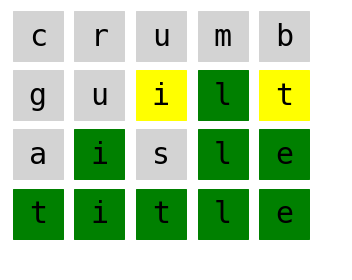

In [3]:
"""
Play a Wordle game to test the above functions.
"""
secret = "title"
guesses = ["crumb", "guilt", "aisle", "title"]

secret = np.array([letter for letter in secret]).astype("|S1")
guesses = np.array([[letter for letter in word] for word in guesses]).astype('|S1')

colors = np.array([wordle(secret, guess) for guess in guesses])

visualize(guesses, colors)

Now that Wordle has been coded, we have to code a depth-first search of all hard-mode games. First, I precompute all possible pairs of (secret, guess) words and the Wordle coloring and save to a lookup table. Using asint=True, this becomes a 2D array of ints. The depth first search is produced as a recursive algorithm, which at every depth iteration, eliminates valid secret words until only the real secret word is left.

In [5]:
# This takes a long time to run. I save the results to lookup.npy
lookup = np.zeros((guess_words.shape[0], guess_words.shape[0]), dtype=int)
for i in range(guess_words.shape[0]):
    for j in range(guess_words.shape[0]):
        lookup[i,j] = wordle(guess_words[i], guess_words[j], asint=True)
lookup = np.save("lookup.npy", lookup)
lookup = np.load("lookup.npy")

In [7]:
"""
Depth-first search.
"""
def depth_first_search(secret, guess, valid_secrets):
    # base case: guess is secret
    if(np.all(secret_words[secret] == guess_words[guess])):
        return 0, []
    # eliminate from valid secrets based on guess
    colors = lookup[secret+12546, guess]
    valid_secrets_ = valid_secrets[lookup[valid_secrets,guess] == colors]
    # depth-first search
    guess_list = []
    depth = 0
    for new_guess in valid_secrets_:
        prop_depth, prop_guess_list = depth_first_search(secret, new_guess, valid_secrets_)
        if(prop_depth + 1 > depth):
            depth = prop_depth + 1; guess_list = [new_guess] + prop_guess_list
    return depth, guess_list

In [ ]:
# the main method
if __name__ == '__main__':
    verbose = True
    count = 0 # count all iterations for percent completion
    # go through all secret words
    best_depth = 0
    best_guesses = []
    best_secret = ""
    for secret in range(secret_words.shape[0]):
        # start depth-first search with every guess
        for guess in range(guess_words.shape[0]):
            valid_secrets = np.arange(guess_words.shape[0], dtype=int)
            depth, guess_list = depth_first_search(secret, guess, valid_secrets)
            depth += 1
            count += 1
            if(depth > best_depth):
                best_depth = depth
                guess_list = [guess] + guess_list
                best_guesses = ["".join(guess_words[i].astype(str)) for i in guess_list]
                best_secret = "".join(secret_words[secret].astype(str))
            if(verbose and count % 200 == 0):
                print("%d done %f percent complete"%(count, 100*count/(guess_words.shape[0]*secret_words.shape[0])))
                print("best found so far: depth %d secret word %s"%(best_depth, best_secret))
                print("guess list: " + " ".join(["".join(word) for word in best_guesses]))

200 done 0.000583 percent complete
best found so far: depth 11 secret word aback
guess list: added agogo ahuru allyl ajwan abaft abamp abaca abaci abacs aback
400 done 0.001166 percent complete
best found so far: depth 11 secret word aback
guess list: added agogo ahuru allyl ajwan abaft abamp abaca abaci abacs aback
600 done 0.001749 percent complete
best found so far: depth 11 secret word aback
guess list: added agogo ahuru allyl ajwan abaft abamp abaca abaci abacs aback
800 done 0.002332 percent complete
best found so far: depth 11 secret word aback
guess list: added agogo ahuru allyl ajwan abaft abamp abaca abaci abacs aback
1000 done 0.002915 percent complete
best found so far: depth 11 secret word aback
guess list: added agogo ahuru allyl ajwan abaft abamp abaca abaci abacs aback
1200 done 0.003499 percent complete
best found so far: depth 11 secret word aback
guess list: added agogo ahuru allyl ajwan abaft abamp abaca abaci abacs aback
1400 done 0.004082 percent complete
best fou

In [8]:
secret = 0
guess = 1
valid_secrets = np.arange(guess_words.shape[0], dtype=int)

depth, wordlist = depth_first_search(secret, guess, valid_secrets)

In [12]:
guess_words.shape

(14855, 5)

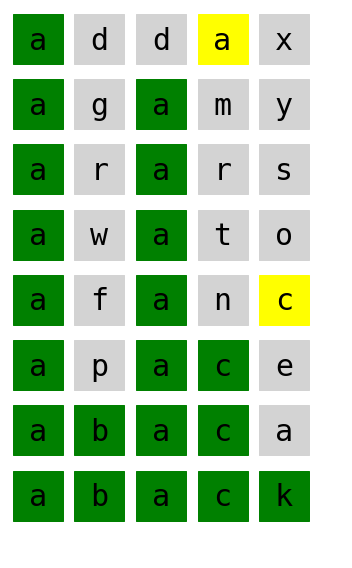

In [9]:
guesses = guess_words[wordlist]
secret = secret_words[0]

colors = np.array([wordle(secret, guess) for guess in guesses])

visualize(guesses, colors)

In [21]:
print("guess list: " + " ".join(["".join(word) for word in best_guesses]))

guess list: aargh aflaj ataxy awave abamp aband abaca abaci abacs aback
